In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
file="/its/home/drs25/Documents/GitHub/RoboSkin/Code/Models/TacTip reader/dots/" #"C:/Users/dexte/github/RoboSkin/Code/Models/TacTip reader/dots/"

## Load dataset

(990, 133, 2) (990, 480, 640, 3)


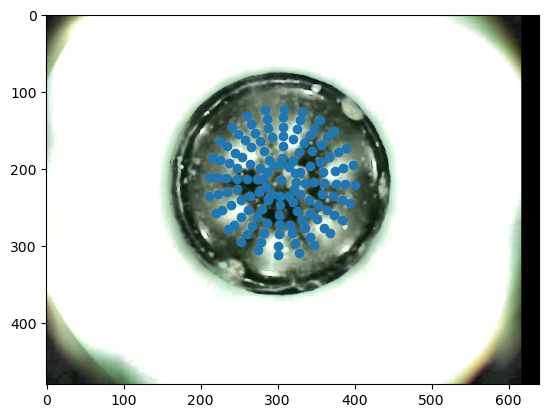

In [2]:
#load dataset
y=np.load(file+"augmentedNewTacTip.npy")
X=np.load(file+"augmentedNewTacTipimages.npy")
print(y.shape,X.shape)
plt.imshow(X[0])
plt.scatter(y[0,:,0],y[0,:,1])
plt.show()

-270 -260


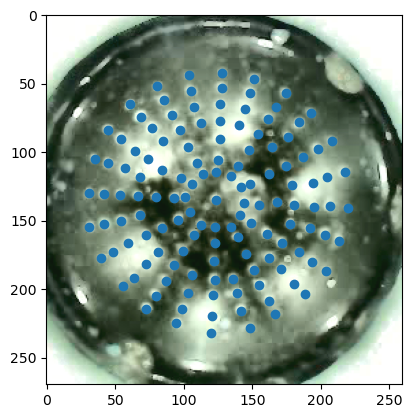

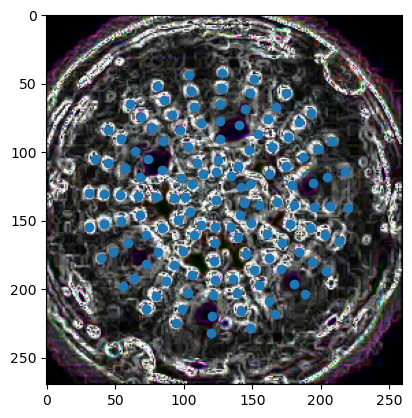

In [26]:
#crop dataset
print(80-350,180-440)
X_=X[:,80:350,180:440].copy()
y_=y.copy()
y_[:,:,0]-=180
y_[:,:,1]-=80
plt.imshow(X_[0])
plt.scatter(y_[0,:,0],y_[0,:,1])
plt.show()
#sobel filter
def applySobel(X):
    for i in range(len(X)): #crop all images individually
        image=X[i]
        # Apply Sobel filter in x-direction
        sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)  # ksize=3 for a 3x3 Sobel kernel

        # Apply Sobel filter in y-direction
        sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

        # Convert the results back to uint8
        sobel_x = np.uint8(np.absolute(sobel_x))
        sobel_y = np.uint8(np.absolute(sobel_y))

        # Combine the results to get the final edge-detected image
        sobel_combined = cv2.bitwise_or(sobel_x, sobel_y)
        X[i]=sobel_combined
    return X_
X_=applySobel(X_)
plt.imshow(X_[0])
plt.scatter(y_[0,:,0],y_[0,:,1])
plt.show()

# Modelling

In [4]:
from sklearn.linear_model import Ridge

X_flat=X.reshape((X.shape[0],-1))
y_flat=y.reshape((y.shape[0],-1))
print(X_flat.shape,y_flat.shape)
X_train, X_test, y_train, y_test = train_test_split(X_flat, y_flat, test_size=0.2, random_state=42)

clf = Ridge(alpha=1.0)
clf.fit(X_train, y_train)

coords=clf.predict(X_test)
error=np.sum(np.sqrt(np.sum(np.square(coords-y_test),axis=1)))



(990, 921600) (990, 266)


: 

: 

In [69]:
# Calculate the Euclidean distance for each pair of points
distances = np.linalg.norm(coords - y_test, axis=1)

# Find the maximum, minimum, and average distances
max_distance = np.max(distances)
min_distance = np.min(distances)
average_distance = np.mean(distances)
print(f"Maximum Euclidean distance: {max_distance}")
print(f"Minimum Euclidean distance: {min_distance}")
print(f"Average Euclidean distance: {average_distance}")

Maximum Euclidean distance: 266.28275040350866
Minimum Euclidean distance: 14.435538518539687
Average Euclidean distance: 54.669521265351754


In [34]:
#save mode;
import pickle
pickle.dump(clf, open('/its/home/drs25/Documents/GitHub/RoboSkin/Code/Models/TacTip reader/pickle_imputer2.pkl', 'wb'))

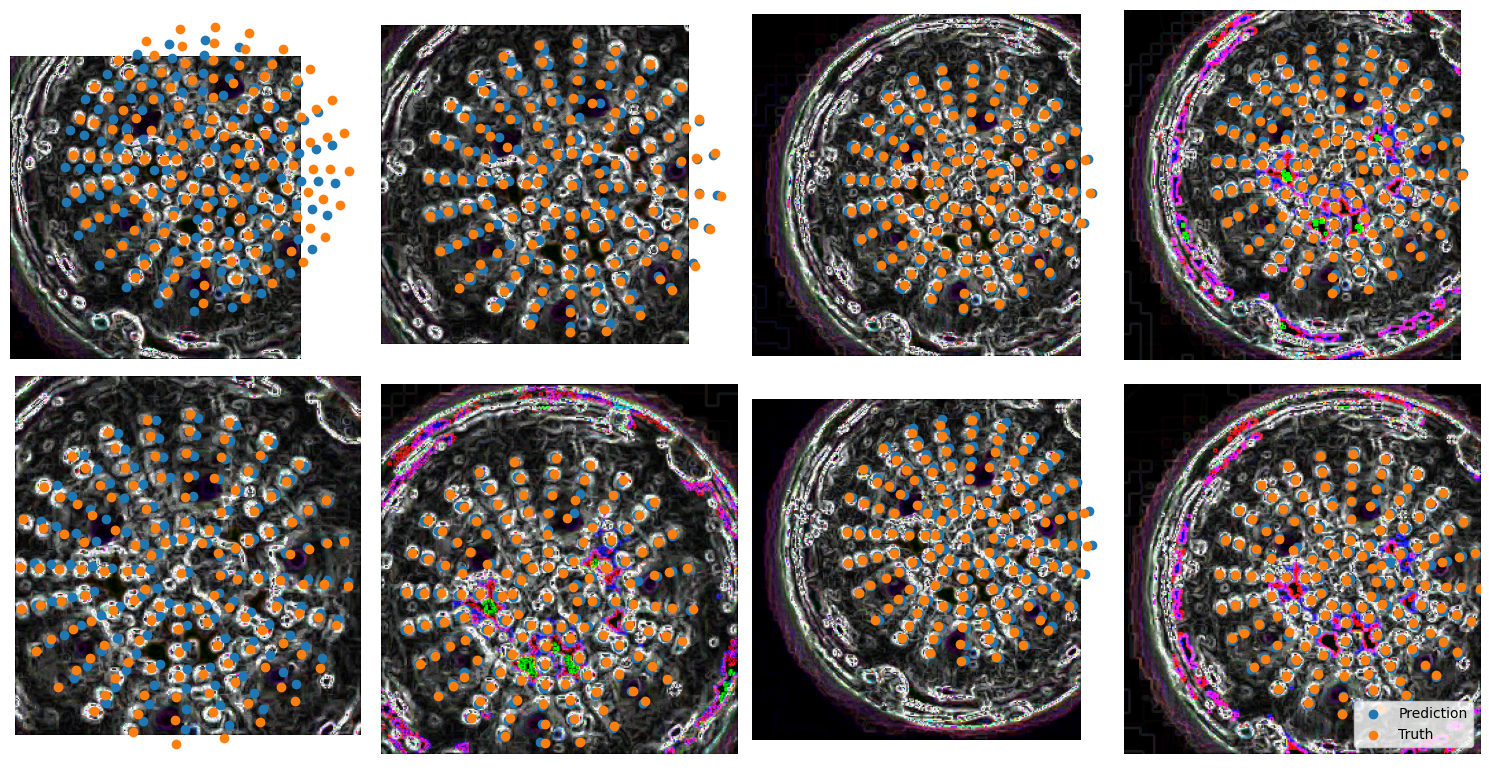

In [56]:
fig, axes = plt.subplots(2, 4, figsize=(15,8))
axes = axes.flatten()

for i in range(8):
    preds=coords.reshape((len(coords),133,2))

    truth=y_test.reshape((len(y_test),133,2))

    axes[i].imshow(X_test[i].reshape((270,260,3)))
    axes[i].scatter(preds[i,:,0],preds[i,:,1],label="Prediction")
    axes[i].scatter(truth[i,:,0],truth[i,:,1],label="Truth")
    axes[i].axis("off")

plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/images/regressionPointPred.pdf")
plt.show()